
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from itertools import cycle
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 140
plt.style.use('seaborn-v0_8-whitegrid')

print("="*80)
print("MACHINE LEARNING ALGORITHMS COMPARISON ON IRIS DATASET")
print("="*80)
OUT_DIR = 'iris_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print(f"\nDataset Overview:")
print(f"Features: {feature_names}")
print(f"Target Classes: {target_names}")
print(f"Dataset Shape: {X.shape}")
print(f"Target Shape: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


algorithms = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

results = {}

print("\n" + "="*80)
print("TRAINING AND EVALUATION")
print("="*80)


for name, algorithm in algorithms.items():
    print(f"\nTraining {name}...")

    # Use scaled data for algorithms sensitive to feature scaling
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        algorithm.fit(X_train_scaled, y_train)
        y_pred = algorithm.predict(X_test_scaled)
        y_pred_proba = algorithm.predict_proba(X_test_scaled)
    else:
        algorithm.fit(X_train, y_train)
        y_pred = algorithm.predict(X_test)
        y_pred_proba = algorithm.predict_proba(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'model': algorithm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"  Accuracy:   {accuracy:.4f}")
    print(f"  Precision:  {precision:.4f}")
    print(f"  Recall:     {recall:.4f}")
    print(f"  F1-Score:   {f1:.4f}")

print("\n" + "="*80)
print("CONFUSION MATRICES (saved as image)")
print("="*80)

n_models = len(results)
cols = 3
rows = int(np.ceil(n_models / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.6*rows))
axes = np.array(axes).reshape(rows, cols)

for ax in axes.ravel():
    ax.axis('off')

for (name, res), ax in zip(results.items(), axes.ravel()):
    cm = res['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.axis('on')

plt.tight_layout()
cm_path = os.path.join(OUT_DIR, 'confusion_matrices.png')
plt.savefig(cm_path, bbox_inches='tight')
plt.close(fig)
print(f"Saved: {cm_path}")


print("\n" + "="*80)
print("ROC CURVES AND AUC (saved per model)")
print("="*80)

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for name, res in results.items():
    y_proba = res['y_pred_proba']

    fpr = {}
    tpr = {}
    roc_auc = {}

    fig, ax = plt.subplots(figsize=(5, 4))
    for i in range(len(target_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax.plot(fpr[i], tpr[i], color=class_colors[i], lw=2,
                label=f"{target_names[i]} (AUC = {roc_auc[i]:.3f})")

    # Macro-average AUC
    macro_auc = np.mean(list(roc_auc.values()))
    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curves: {name} (Macro AUC = {macro_auc:.3f})')
    ax.legend(loc='lower right')
    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, f"roc_{name.replace(' ', '_').lower()}.png")
    plt.savefig(out_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {out_path}")


print("\n" + "="*80)
print("FEATURE IMPORTANCE IMAGES")
print("="*80)

from sklearn.inspection import permutation_importance

for name, res in results.items():
    model = res['model']

    # Determine data space used for model
    X_tr = X_train_scaled if name in ['Logistic Regression', 'SVM', 'KNN'] else X_train
    X_te = X_test_scaled if name in ['Logistic Regression', 'SVM', 'KNN'] else X_test

    importances = None
    title_suffix = ''

    # Tree-based native importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        title_suffix = '(Gini importance)'

    # Coefficients for linear models (use absolute mean across classes for multinomial)
    elif hasattr(model, 'coef_'):
        coef = model.coef_
        if coef.ndim == 2:  # multiclass one-vs-rest or multinomial
            importances = np.mean(np.abs(coef), axis=0)
        else:
            importances = np.abs(coef)
        title_suffix = '(|coefficients|)'

    # Fallback: permutation importance (slower but model-agnostic)
    else:
        pi = permutation_importance(model, X_te, y_test, n_repeats=20, random_state=42, n_jobs=-1)
        importances = pi.importances_mean
        title_suffix = '(permutation importance)'

    # Normalize to sum to 1 for clean comparison
    importances = np.array(importances)
    if importances.ndim > 1:
        importances = importances.ravel()
    total = importances.sum()
    if total > 0:
        importances = importances / total

    # Plot bar chart
    order = np.argsort(importances)[::-1]
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=importances[order], y=np.array(feature_names)[order], ax=ax, color='#4e79a7')
    ax.set_xlabel('Relative importance')
    ax.set_ylabel('Feature')
    ax.set_title(f"Feature Importance: {name} {title_suffix}")
    plt.tight_layout()
    out_path = os.path.join(OUT_DIR, f"feature_importance_{name.replace(' ', '_').lower()}.png")
    plt.savefig(out_path, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {out_path}")

names = []
accs = []
f1s = []
for name, res in results.items():
    names.append(name)
    accs.append(res['accuracy'])
    f1s.append(res['f1_score'])

fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.4
idx = np.arange(len(names))
ax.bar(idx - bar_width/2, accs, width=bar_width, label='Accuracy')
ax.bar(idx + bar_width/2, f1s, width=bar_width, label='F1-Score')
ax.set_xticks(idx)
ax.set_xticklabels(names, rotation=20, ha='right')
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title('Model Performance Summary')
ax.legend()
plt.tight_layout()
sum_path = os.path.join(OUT_DIR, 'summary_accuracy_f1.png')
plt.savefig(sum_path, bbox_inches='tight')
plt.close(fig)
print("\nSummary saved:", sum_path)

print("\nAll requested images are saved under:", os.path.abspath(OUT_DIR))

In [12]:
# Section 4: Evaluate metrics function
def evaluate_metrics(y_true, y_pred, average='macro'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

metrics_summary = []
for name, res in results.items():
    acc, prec, rec, f1 = evaluate_metrics(y_test, res['y_pred'])
    metrics_summary.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

metrics_df = pd.DataFrame(metrics_summary)
print("\nModel Performance Summary:")
display(metrics_df.sort_values(by='Accuracy', ascending=False))


Model Performance Summary:


Model  Accuracy  Precision    Recall  F1-Score
1        Decision Tree  0.933333   0.944444  0.933333  0.932660
3                  SVM  0.933333   0.934524  0.933333  0.933259
0  Logistic Regression  0.911111   0.915535  0.911111  0.910714
2        Random Forest  0.911111   0.915535  0.911111  0.910714
4                  KNN  0.911111   0.929825  0.911111  0.909502
5          Naive Bayes  0.911111   0.915535  0.911111  0.910714


Confusion Matrices:


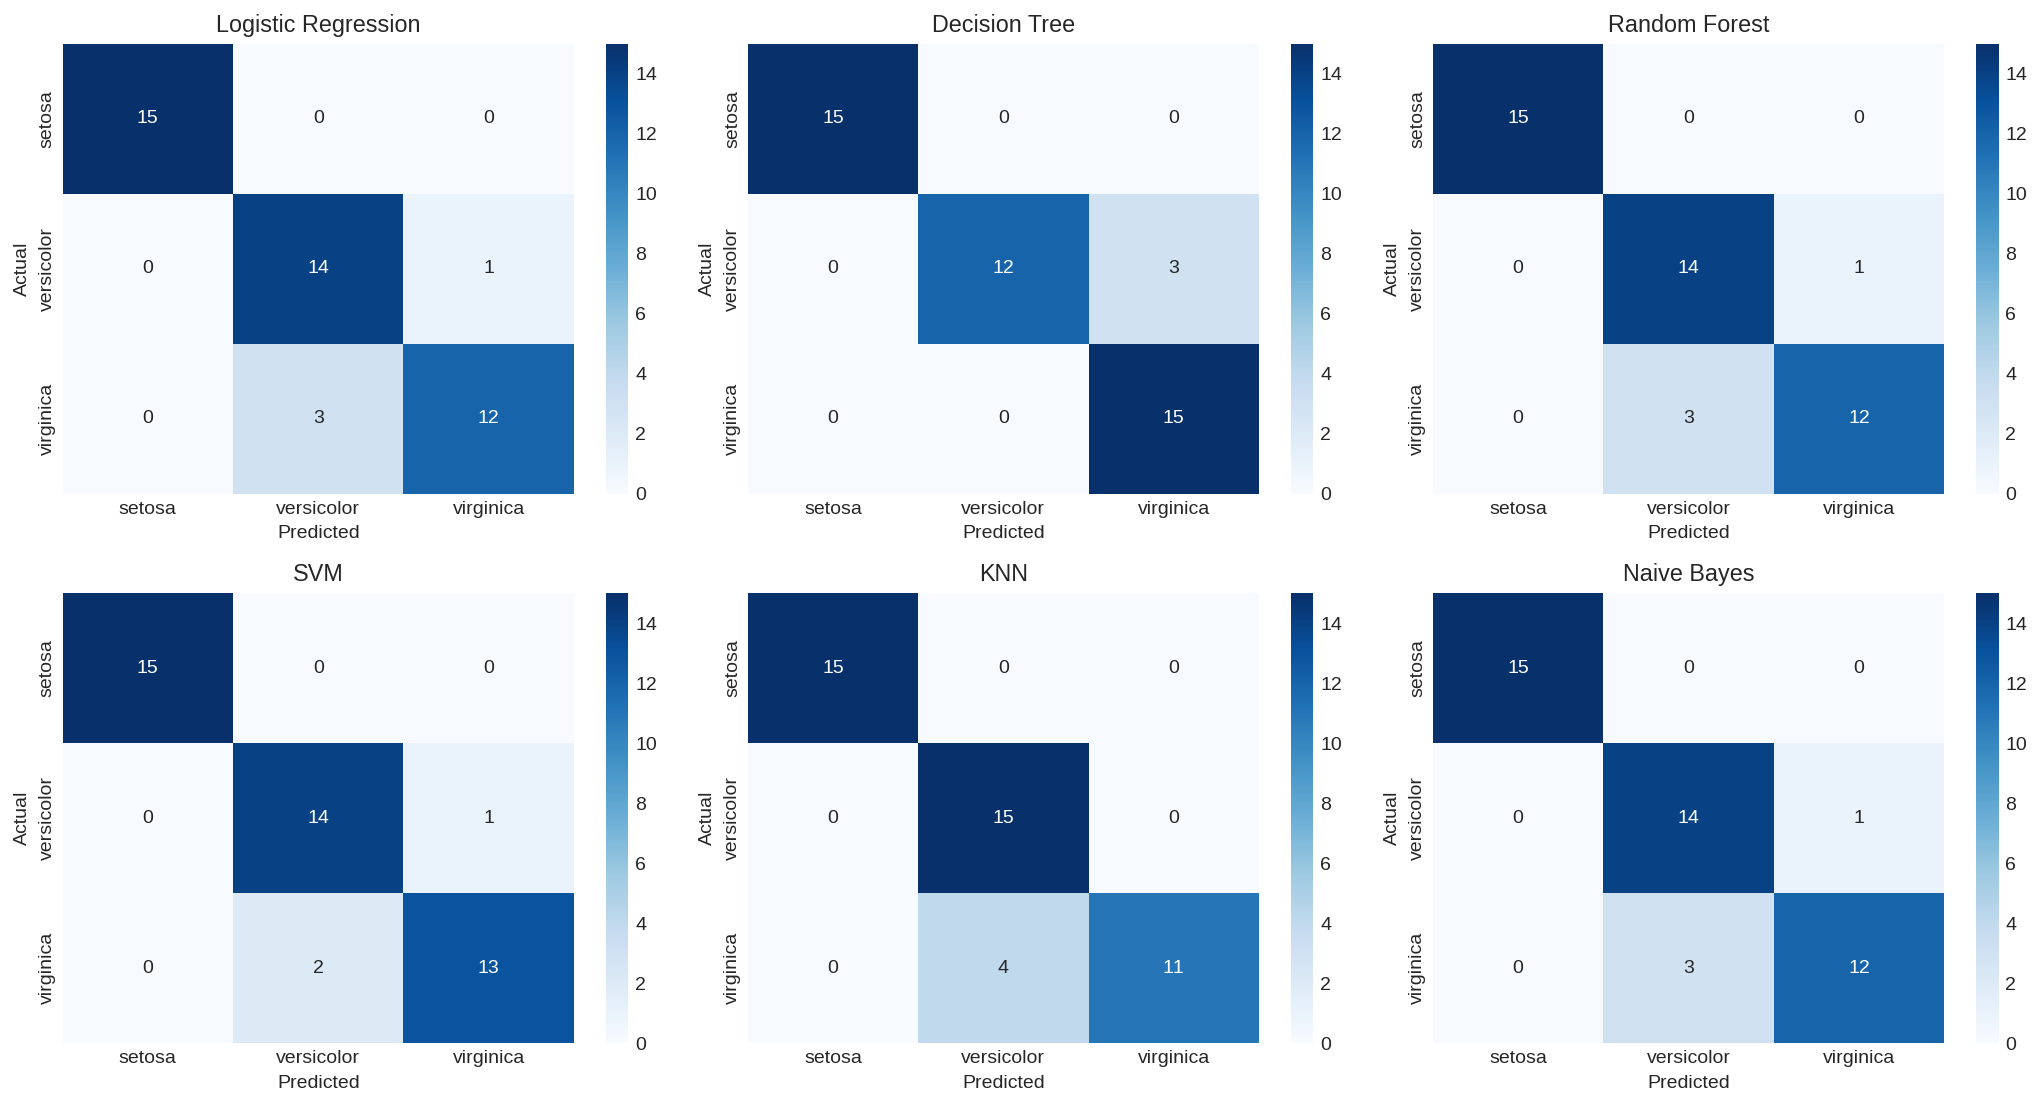

In [13]:
# Section 5: Confusion Matrices
print("\nConfusion Matrices:")
n_models = len(models)
cols = 3
rows = (n_models + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=iris.target_names, yticklabels=iris.target_names)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


ROC Curves:


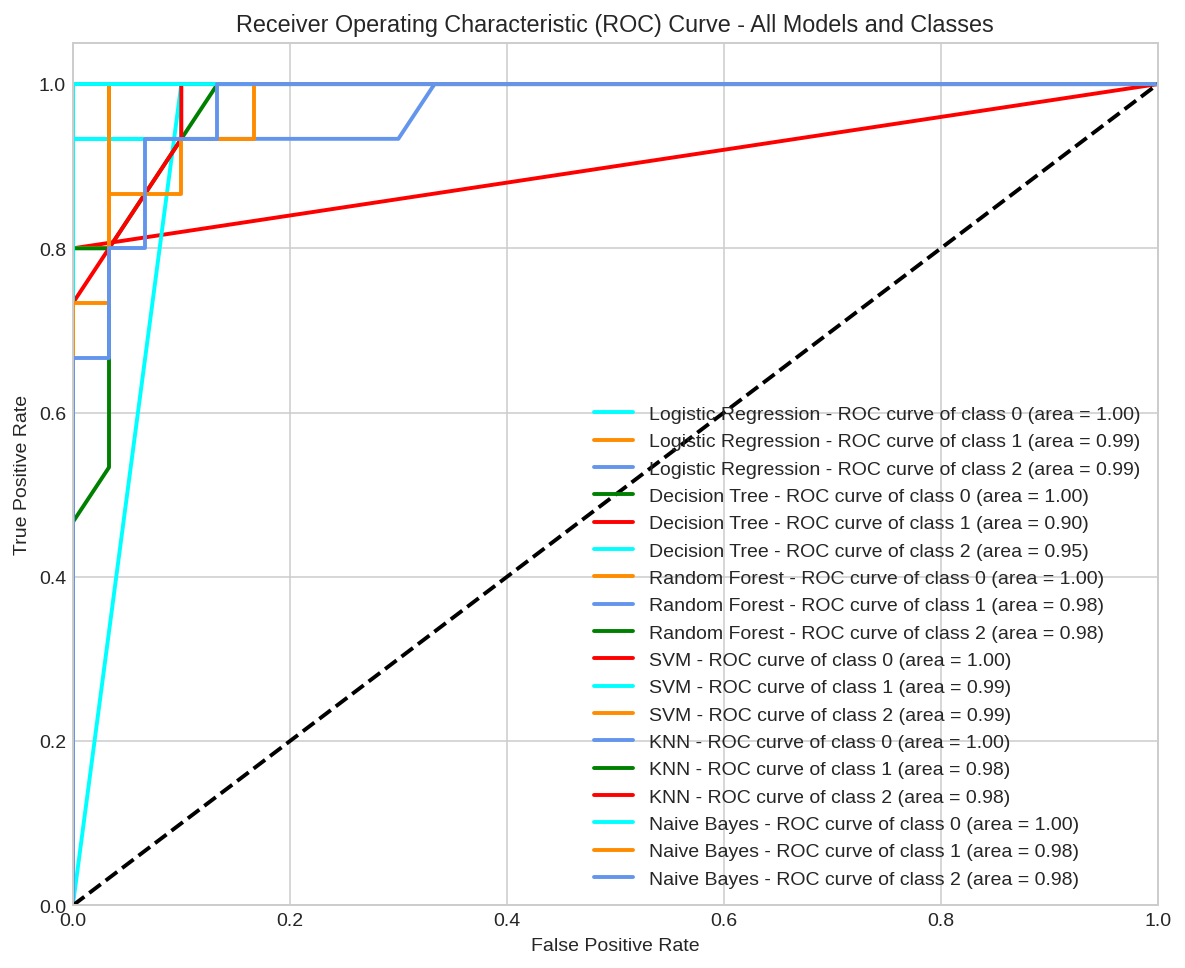

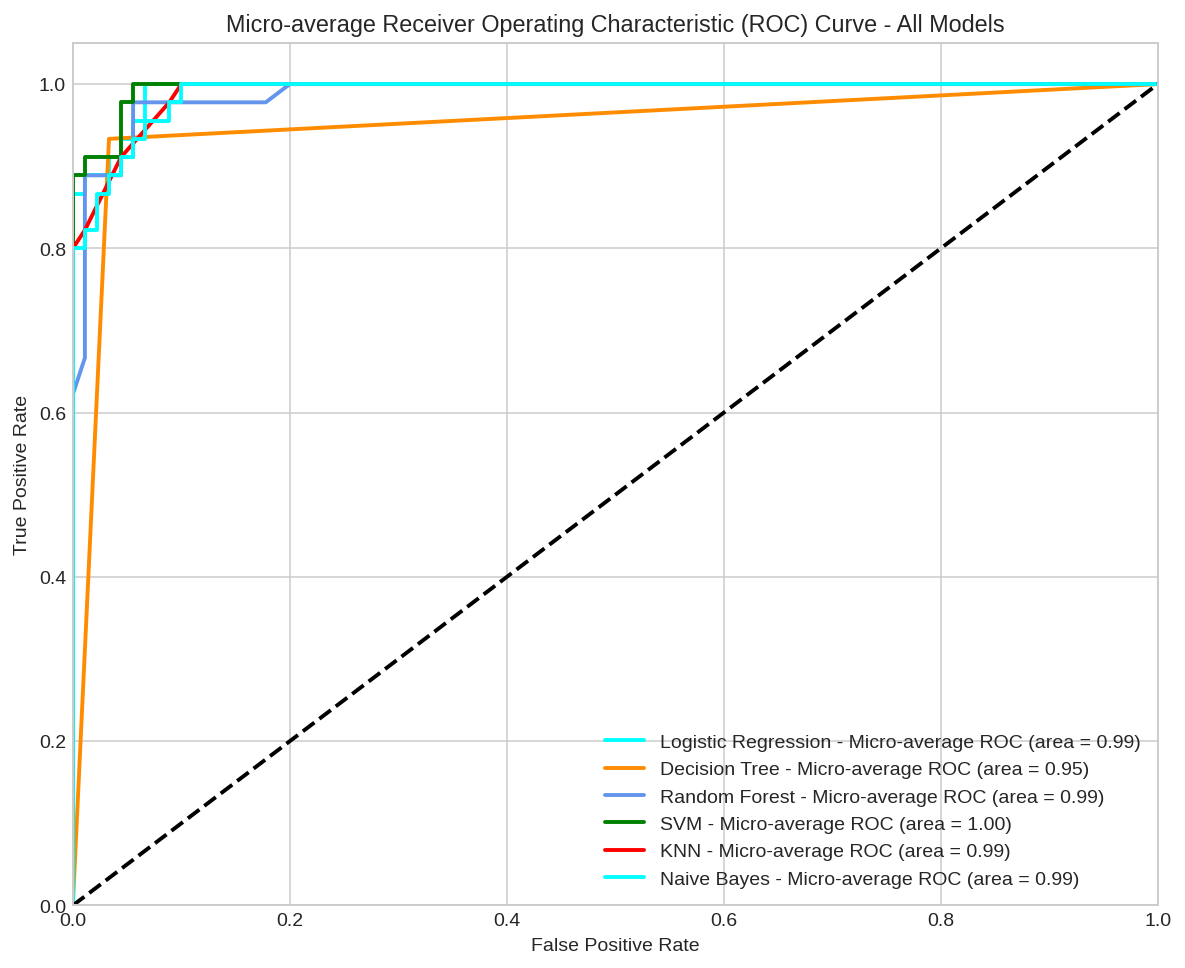

In [16]:
# Section 6: ROC Curves
print("\nROC Curves:")
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for i, (name, res) in enumerate(results.items()):
    y_prob = res['y_pred_proba']

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_prob[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot all ROC curves for this model
    for j, color in zip(range(n_classes), colors):
         plt.plot(fpr[j], tpr[j], color=color, lw=2,
                 label=f'{name} - ROC curve of class {j} (area = {roc_auc[j]:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - All Models and Classes')
plt.legend(loc="lower right")
plt.show()

# Plot micro-average ROC curve for each model
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for i, (name, res) in enumerate(results.items()):
    y_prob = res['y_pred_proba']

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], color=next(colors), lw=2,
             label=f'{name} - Micro-average ROC (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve - All Models')
plt.legend(loc="lower right")
plt.show()